In [1]:
# import libraries
import os, sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm

frequency = 'monthly'

# Set project root and change working directory
project_root = Path.cwd().parent.parent  # src/notebook/ is two levels below root
os.chdir(project_root)  # Change to project root so PriceManager can find data/
print(f"📁 Working directory: {os.getcwd()}")

# Add src directory to Python path
sys.path.insert(0, str(project_root / "src"))

from tiingo import TiingoClient
from core.config import Config
from market import PriceManager
from universe import SP500Universe

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

# Initialize configuration and components - USE ABSOLUTE PATH
config = Config(str(project_root / "config/settings.yaml"))
universe = SP500Universe()

# Initialize Tiingo client and PriceManager
tiingo = TiingoClient({
    'api_key': config.get('fetcher.tiingo.api_key'),
    'session': True
})

price_mgr = PriceManager(tiingo=tiingo, universe=universe)

print("✅ Components initialized successfully")

📁 Working directory: /Users/frank/Projects/QuantX/quantx-data-builder
✅ Libraries imported successfully
✅ Components initialized successfully


In [2]:

'''
Read monthly prices of PEP and S&P 500 index (SPY) for 5-year beta calculation
5 years of monthly data ending October 2025
start period: 2020-11-01 (5 years back)
end period: 2025-10-31 (last complete month)
period format: YYYY-MM-DD
'''
spy_monthly = price_mgr.load_market_etf_data(
    frequency=frequency,
    start_date='2020-11-01',
    end_date='2025-10-31'
)

ticker = 'AAPL'

aapl_monthly = price_mgr.load_price_data(
    symbol=ticker,
    frequency=frequency,
    start_date='2020-11-30',
    end_date='2025-10-31'
)
    

print(f"SPY columns: {spy_monthly.columns.tolist()}")
print(f"{ticker} columns: {aapl_monthly.columns.tolist()}")

# joining the closing prices of the two datasets with same date index
# Both datasets are indexed by date, ensuring proper alignment
monthly_prices = pd.DataFrame({
    ticker: aapl_monthly.set_index('date')['adj_close'],
    'SPY': spy_monthly.set_index('date')['adj_close'],
})

print(f"\n📊 Monthly prices shape: {monthly_prices.shape}")
print(f"Date range: {monthly_prices.index.min()} to {monthly_prices.index.max()}")
print(f"Number of matching dates: {len(monthly_prices.dropna())}")
print(monthly_prices.head())

# calculate monthly returns
monthly_returns = monthly_prices.pct_change(1)
clean_monthly_returns = monthly_returns.dropna(axis=0)  # drop first missing row
print("Monthly Returns:")
print(clean_monthly_returns.head())


SPY columns: ['gvkey', 'date', 'open', 'high', 'low', 'close', 'volume', 'adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume', 'div_cash', 'split_factor', 'exchange', 'currency', 'freq', 'year']
AAPL columns: ['gvkey', 'date', 'open', 'high', 'low', 'close', 'volume', 'adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume', 'div_cash', 'split_factor', 'exchange', 'currency', 'freq', 'year']

📊 Monthly prices shape: (60, 2)
Date range: 2020-11-30 to 2025-10-31
Number of matching dates: 60
                  AAPL         SPY
date                              
2020-11-30  115.901686  337.442343
2020-12-31  129.180972  349.949980
2021-01-29  128.470277  346.383837
2021-02-26  118.230201  356.015230
2021-03-31  119.097963  372.180116
Monthly Returns:
                AAPL       SPY
date                          
2020-12-31  0.114574  0.037066
2021-01-29 -0.005502 -0.010190
2021-02-26 -0.079708  0.027806
2021-03-31  0.007340  0.045405
2021-04-30  0.076218  0.052910


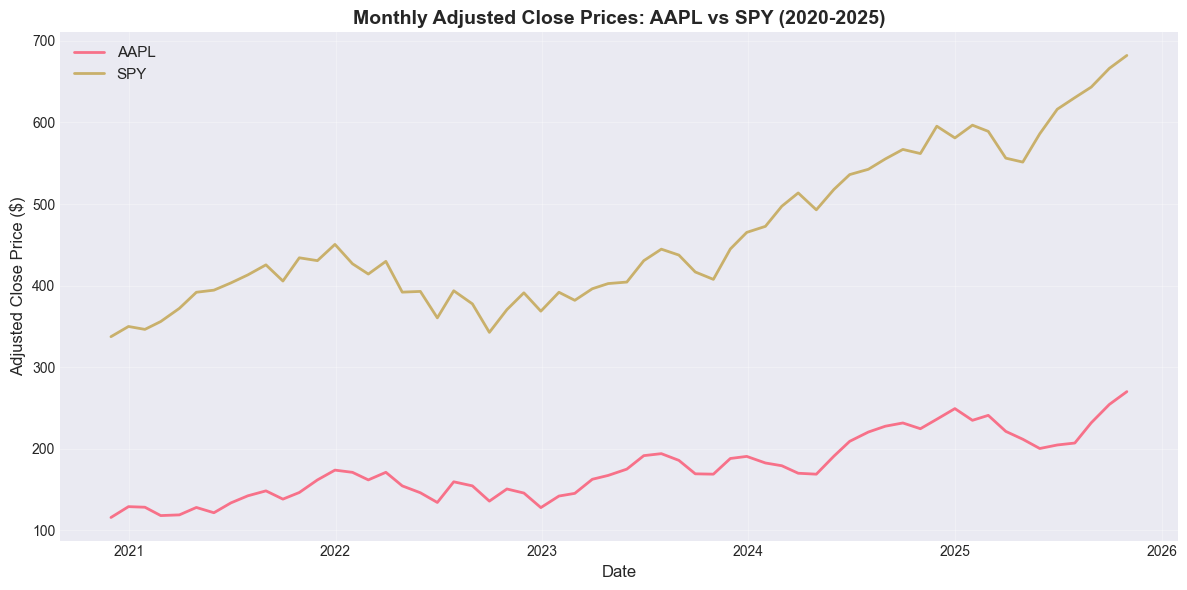

✅ Price chart plotted successfully


In [3]:
# Plot monthly prices
plt.figure(figsize=(12, 6))
plt.plot(monthly_prices.index, monthly_prices[ticker], label=ticker, linewidth=2)
plt.plot(monthly_prices.index, monthly_prices['SPY'], label='SPY', linewidth=2, alpha=0.7)
plt.title(f'Monthly Adjusted Close Prices: {ticker} vs SPY (2020-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price ($)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Price chart plotted successfully")

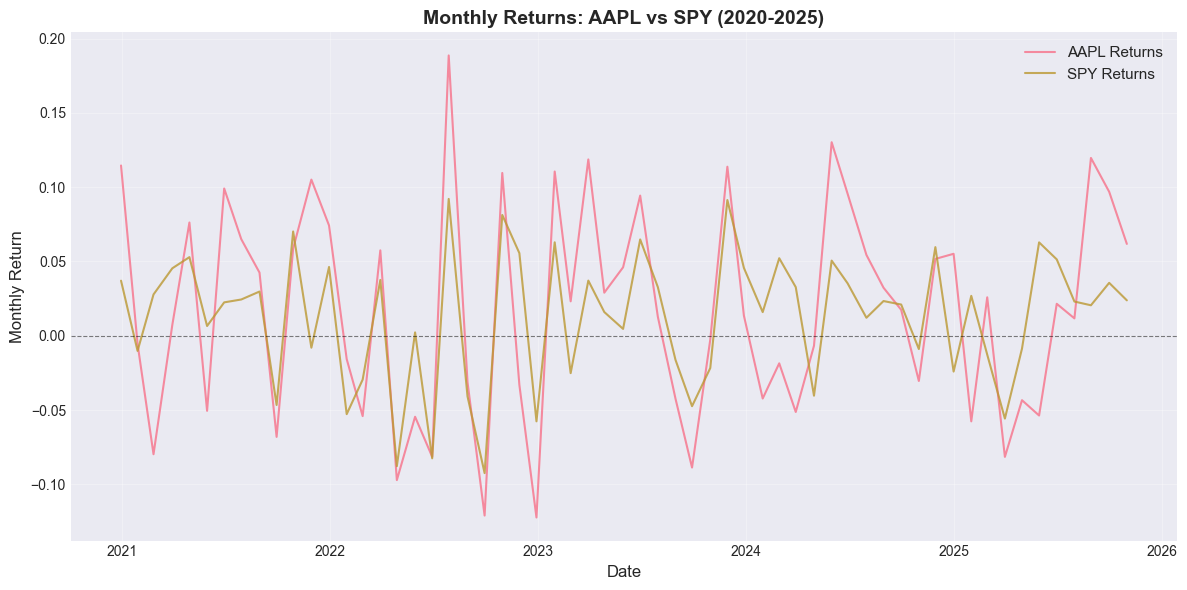


📊 Return Statistics:
            AAPL        SPY
count  59.000000  59.000000
mean    0.016974   0.012960
std     0.072295   0.044138
min    -0.122273  -0.092416
25%    -0.042869  -0.014473
50%     0.017467   0.023031
75%     0.069606   0.045534
max     0.188634   0.092087


In [4]:
# Plot monthly returns
plt.figure(figsize=(12, 6))
plt.plot(clean_monthly_returns.index, clean_monthly_returns[ticker], label=f'{ticker} Returns', linewidth=1.5, alpha=0.8)
plt.plot(clean_monthly_returns.index, clean_monthly_returns['SPY'], label='SPY Returns', linewidth=1.5, alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.title(f'Monthly Returns: {ticker} vs SPY (2020-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Return', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics for returns
print("\n📊 Return Statistics:")
print(clean_monthly_returns.describe())

In [5]:
import statsmodels.api as sm

# split dependent and independent variable
X = clean_monthly_returns['SPY'].values
Y = clean_monthly_returns[ticker].values

def linreg(x,y):
    x = sm.add_constant(x)
    # model = regression.linear_model.OLS(y, x).fit()
    model = sm.OLS(y, x).fit()

    # We are removing the constant
    # x = x[:,1]
    return model

pep_result = linreg(X, Y)

print(pep_result.summary())

# alpha, beta = linreg(X, Y)
alpha_pep = pep_result.params[0]
beta_pep = pep_result.params[1]
print('alpha:', alpha_pep)
print('beta:', beta_pep)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     47.54
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           4.76e-09
Time:                        00:09:16   Log-Likelihood:                 89.673
No. Observations:                  59   AIC:                            -175.3
Df Residuals:                      57   BIC:                            -171.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.007      0.364      0.7

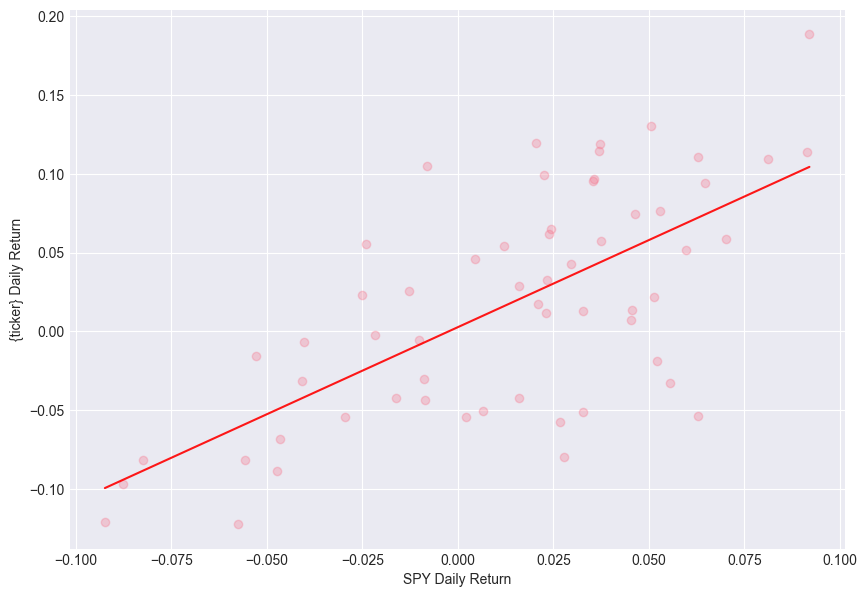

In [6]:
# Plotting
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta_pep + alpha_pep
plt.figure(figsize=(10,7))
plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("{ticker} Daily Return")
plt.plot(X2, Y_hat, 'r', alpha=0.9)
plt.show()